In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
from tqdm import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
import pandahouse as ph

In [2]:
#                                                   Задание 1

In [3]:
groups_df = pd.read_csv(r'/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_groups.csv', sep=';', encoding = 'utf-8') #судя по всему, файлы
# неправильно были сохранены в csv формат, из-за чего некоторые строки не считываются корректно, т.к. при их просмотре в  
# текстовом редакторе каких-либо ошибок не видно. Можно пересохранить их или игнорировать строки, вызывающие ошибку 
# (параметр error_bad_lines метода read_csv должен быть равен False).

info_df = pd.read_csv(r'/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_active_studs.csv', sep=';', encoding = 'utf-8')

cheks_df = pd.read_csv(r'/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_checks.csv', sep=';', encoding = 'utf-8')

In [4]:
# проверим данные на предмет пустых значений 
groups_df.isna().sum()

id     0
grp    0
dtype: int64

In [5]:
info_df.isna().sum()

student_id    0
dtype: int64

In [6]:
cheks_df.isna().sum()

student_id    0
rev           0
dtype: int64

In [7]:
# получим данные о чеках активных во время теста пользователей, которые отнесены к какой-либо группе 
merged_checks = cheks_df.merge(right = info_df, how = 'inner', on = 'student_id').\
                merge(right = groups_df, how = 'inner', left_on = 'student_id', right_on = 'id') 
merged_checks = merged_checks.drop(columns = 'id') # удалим лишнюю колонку 
group_A = merged_checks[merged_checks['grp'] == 'A'].reset_index(drop = True) # переназначим index 
group_B = merged_checks[merged_checks['grp'] == 'B'].reset_index(drop = True) # переназначим index
group_A

,student_id,rev,grp
0,1627,990.0,A
1,287008,1830.0,A
2,332387,2910.0,A
3,347455,2820.0,A
4,445767,3660.0,A
...,...,...,...
73,5394575,990.0,A
74,5545563,1160.0,A
75,5557468,290.0,A
76,5567520,489.0,A


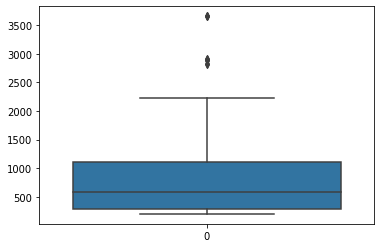

In [8]:
sns.boxplot(data = group_A['rev']) # проверим данные на наличие выбросов 

In [9]:
# имеются выбросы, что может исказить результаты Т-теста 

In [10]:
st.shapiro(group_A['rev']) # проверка на нормальность распределения  
# распределение нельзя считать нормальным, поэтому для АА-теста лучше не использовать Т-тест 

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

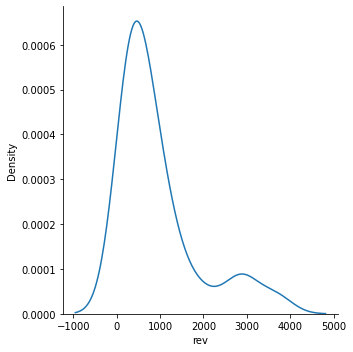

In [11]:
sns.displot(data=group_A['rev'], kind="kde") # распределение данных в группе А 

In [12]:
# распределение нельзя считать нормальным 
# предполагается использовать U-тест Манна-Уитни для двух независимых выборок (мы принимаем, что выборки такие, 
# т.к. выбранные значения не возвращаются в исходный массив данных, а повторных данных от одного пользователя не поступало)

In [13]:
def AA_test(df, column_name, number_in_sample = 0, iterations = 10000):
    if number_in_sample == 0:
         number_in_sample = int(df.shape[0]/2) # определяем кол-во элементов сэмпла на основе размера переданного датафрейма
    results = []
    FP = 0
    for i in tqdm(range(0, iterations)):
        sample_1 = df.sample(n = number_in_sample)[column_name] # делаются случайные выборки одинакового размера без возвращения элементов
        sample_2 = df.sample(n = number_in_sample)[column_name]
        results.append(st.mannwhitneyu(sample_1, sample_2)[1]) # сохраняются значения p-value Т-теста в список 
        if results[i] < 0.05: # считаем число ложноположительных результатов
            FP += 1 
    plt.xlabel('p-values')
    sns.histplot(data= results) # строим гистограмму с распределением p-value выборок, созданных во время АА-теста
    plt.show()
    return f'FPR = {FP/iterations}' 

100%|██████████| 20000/20000 [00:37<00:00, 526.52it/s]


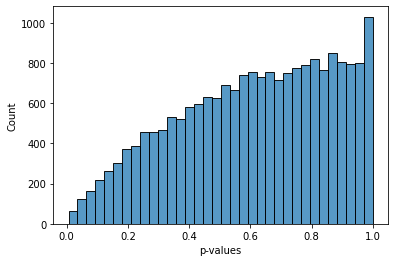

'FPR = 0.00605'

In [14]:
AA_test(group_A, column_name = 'rev', iterations = 20000)

In [15]:
# Согласно результатам АА-теста исходные данные не отличаются сами от себя (FPR < уровень значимости)

In [16]:
st.levene(group_A['rev'], group_B['rev']) # проверка на гомогенность дисперсии 
# дисперсии можно признать равными 

LeveneResult(statistic=3.0558643506726035, pvalue=0.08123509393501775)

In [17]:
# Посмотрим на соответствие данных в выборке для группы Б нормальному распределению
st.shapiro(group_B['rev'])

ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)

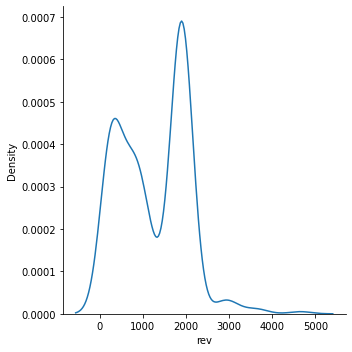

In [18]:
sns.displot(data=group_B['rev'], kind="kde") # распределение данных в группе Б
# по результатам теста и по графику видно, что распределение сильно отклоняется от нормального 

In [19]:
# проведем непараметрический тест Манна-Уитни для АБ-теста (выбран, т.к. распределение выборок не соответствует нормальному)
st.mannwhitneyu(group_A['rev'], group_B['rev'])

MannwhitneyuResult(statistic=8990.0, pvalue=0.000273244700505943)

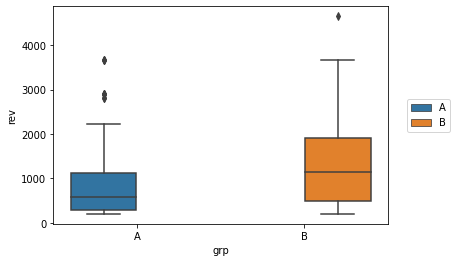

In [20]:
# Построим боксплот для наглядности 
ax = sns.boxplot(data = merged_checks, hue = 'grp', y = 'rev', x = 'grp')
plt.legend(loc = 'center right', bbox_to_anchor=(1.2, 0.5)) # переместим легенду для более удобного отображения 

In [21]:
# Согласно тесту Манна-Уитни группа А значимо отличается от группы Б, однако при визуализации заметно, что в данных есть выбросы
# возможно стоит проверить, как они влияют на результат (хотя непараметрический тест не так сильно подвержден влиянию выбросов) 

In [22]:
drops_B = group_B['rev'].sort_values(ascending = False).reset_index(drop = True) # отсортируем значения и переназначим индексы
# для более удобного поиска выбросов
drops_B.head(15)# как видно из боксплота, для группы Б выбросом является значение, превышающее 4000, в данных такое значение 
# только одно - 4650

0     4650.0
1     3660.0
2     3660.0
3     3260.0
4     3040.0
5     2910.0
6     2910.0
7     2890.0
8     2890.0
9     2890.0
10    2220.0
11    2190.0
12    2099.0
13    2099.0
14    2099.0
Name: rev, dtype: float64

In [23]:
drops_B = drops_B.drop(index = 0) # удаляем выброс
drops_B

1      3660.0
2      3660.0
3      3260.0
4      3040.0
5      2910.0
        ...  
308     199.0
309     199.0
310     199.0
311     199.0
312     199.0
Name: rev, Length: 312, dtype: float64

In [24]:
drops_A = group_A['rev'].sort_values(ascending = False).reset_index(drop = True)# отсортируем значения и переназначим индексы
# для более удобного поиска и удаления выбросов
drops_A.head(15) # судя по боксплоту для группы А выбросами являются значения, превышающие примерно 2300, избавимся от них

0     3660.0
1     3660.0
2     3660.0
3     2910.0
4     2910.0
5     2900.0
6     2890.0
7     2820.0
8     2820.0
9     2220.0
10    1980.0
11    1830.0
12    1530.0
13    1530.0
14    1530.0
Name: rev, dtype: float64

In [25]:
drops_A = drops_A.drop(index = [0,1,2,3,4,5,6,7,8]) # избавимся от выбросов 
drops_A

9     2220.0
10    1980.0
11    1830.0
12    1530.0
13    1530.0
       ...  
73     199.0
74     199.0
75     199.0
76     199.0
77     199.0
Name: rev, Length: 69, dtype: float64

In [26]:
st.mannwhitneyu(drops_B, drops_A) # теперь посмотрим, как одновременное удаление выбросов из групп А и Б влияет на результат 

MannwhitneyuResult(statistic=15301.5, pvalue=2.9795874499994477e-08)

In [27]:
# После удаления выбросов из обеих групп результат теста все равно говорит о статистически значимых различиях между группами.
# На основе проделанного выше анализа можно сделать вывод о том, что различия между группой А и Б статистически значимы, 
# поэтому можно запускать новую механику оплаты на всех пользователей.

In [28]:
################################################################################################################################

In [29]:
#                                                 Задание 2.1

In [30]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',    # задаем параметры подключения к базе данных 
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [31]:
query_good_st = '''SELECT DISTINCT count(st_id) as good_st
FROM 
(   
    SELECT st_id, 
           COUNT(correct) as right_pea,                              -- подсчет числа правильных горошин по дням и часам марта
           solving_day_hour                                          -- для каждого студента 
    FROM 
    (  
        SELECT  st_id, 
                formatDateTime(timest, '%d %H') as solving_day_hour, -- форматирование в день и час для дальнейше группировки
                correct
        FROM default.peas
        WHERE   correct = 1 AND                                      -- выбор правильный решений для дальнейшей их агрегации 
                formatDateTime(timest, '%Y %m') = '2020 03'          -- выбор нужного месяца 
    )
    GROUP BY st_id, solving_day_hour                                 -- группировка для правильного подсчета числа горошин
    HAVING right_pea >= 20                                           -- фильтрация после группировки и агрегации                        
) AS peas '''
good_st_df = ph.read_clickhouse(query=query_good_st, connection=connection_default) 
good_st_df.head(10)

,good_st
0,0


In [32]:
#                                                 Задание 2.2

In [33]:
# в таблице "studs" пользователю с одним и тем же id присвоено несколько значений old или/и new, что неправильно с точки зрения
# создания самих таблиц (есть id, но при этом строки не являются уникальными), а также неверно с точки зрения логики проведения 
# АБ-эксперимента - одного пользователя в рамках одного эксперимента почему-то относят к двум разным группам, либо не 
# содержится информации о разграничении двух разных экспериментов. В данном случае, чтобы корректно соединить таблицы, стоит
# создать в них столбцы с числовыми значениями от 1 до числа, равного кол-ву строк таблицы (ключ). Альтернативным вариантом для
# решения поставленной задачи является использование конструкции WITH. 

In [34]:
# посмотрим на данные таблицы studs, из них видно, что строки с id студента не уникальны 
query_studs = '''SELECT * FROM default.studs'''
q_studs_df = ph.read_clickhouse(query=query_studs, connection=connection_default) 
q_studs_df.head(15)

,st_id,test_grp
0,1EYY37,old
1,1N8MTZ,new
2,1N8MTZ,new
3,1N8MTZ,new
4,1N8MTZ,new
5,1N8MTZ,new
6,1N8MTZ,new
7,1N8MTZ,old
8,1N8MTZ,old
9,1N8MTZ,old


In [35]:
# В трех таблицах даны данные лишь об активных (платящих) пользователях, в этом легко убедиться - число уникальных пользователей
# в таблицах по-отдельности совпадает с числом уникальных пользователей при соединении таблиц типом INNER JOIN.
checks_peas = ph.read_clickhouse('''SELECT  count(DISTINCT(st_id)) as students
FROM (SELECT * 
    FROM default.peas as A
    JOIN default.final_project_check AS B
    ON A.st_id = B.st_id
)
''', connection=connection_default)
checks_peas

,students
0,30


In [36]:
# При этом число уникальных id аналогичное и для таблиц final_project_check, peas, studs
# Это уже позволяет говорить нам о том, что CR в покупку = CR активного пользователя в покупку = 1, ARPU = ARPAU, 
# т.к. имеется информация лишь об активных платящих пользователях
checks = ph.read_clickhouse('''SELECT uniqExact(st_id) as students FROM default.final_project_check''', connection=connection_default)
checks

,students
0,30


In [37]:
peas = ph.read_clickhouse('''SELECT uniqExact(st_id) as students FROM default.peas''', connection=connection_default)
peas

,students
0,30


In [38]:
studs_peas = ph.read_clickhouse('''SELECT  count(DISTINCT(st_id)) as students
FROM (SELECT * 
    FROM default.peas as A
    JOIN default.studs AS B
    ON A.st_id = B.st_id
)
''', connection=connection_default)
studs_peas

,students
0,30


In [39]:
metrics = '''WITH (SELECT uniqExact(st_id) FROM default.final_project_check) as active_users,
    (SELECT sum(money) FROM default.final_project_check) as revenue,
    (SELECT uniqExact(st_id) FROM default.studs) as users,
    (SELECT uniqExact(st_id) FROM default.peas WHERE subject ='Math') as users_math,
    (SELECT uniqExact(st_id) FROM default.final_project_check WHERE subject ='Math') as active_math

SELECT  revenue/active_users as ARPAU, 
        revenue/users as ARPU, 
        active_users/users as CR_active_to_buy,
        active_math/users_math as CR_math'''
metriq_df = ph.read_clickhouse(query = metrics, connection=connection_default)
metriq_df

,ARPAU,ARPU,CR_active_to_buy,CR_math
0,114500.0,114500.0,1.0,1.0


In [40]:
#                                               Задание 3

In [41]:
path_to_additional = '/home/jupyter-i.gorodnichev-15/files_for_project/Проект_2_group_add.csv' # путь дополнительного файла

In [42]:
def additional(path):
    df = pd.read_csv(path_to_additional, sep = ',', encoding = 'utf-8') # считываем дополнительный файл
    added_df = pd.concat([groups_df, df]).reset_index(drop = True) # соединяем счиатнный файл с датафреймом, 
    # содержащим аналогичную по типу информацию
    
    users = added_df.shape[0] # считаем общее число пользователей, пригодится для расчета метрик 
    
    # создадим датафреймы для того, чтобы можно было считать метрики и затем смотреть их распределение по группам пользователей
    active_payable_users = info_df.merge(right = cheks_df, on = 'student_id', how = 'inner').merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id')
    active = info_df
    payable = cheks_df
    active = active.merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id') # при объединении получаем 
    # информацию о разделении пользователей на группы
    payable = payable.merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id')
    
    active_payable_users['CR_active_to_buy'] = 1/users # для расчета реального СР будем суммировать данные в ячейках 
    payable['CR_to_buy'] = 1/users
    payable['ARPU'] = payable['rev']/users
    payable['ARPAU'] = payable['rev']/active.shape[0]
    
    ARPU = payable['ARPU'].sum() #  считаем метрики
    ARPAU =  payable['ARPAU'].sum()
    CR_to_buy = payable['CR_to_buy'].sum()
    CR_active_to_buy = active_payable_users['CR_active_to_buy'].sum()
    
    return f'ARPU = {ARPU}, ARPAU = {ARPAU}, CR_to_buy = {CR_to_buy}, CR_active_to_buy = {CR_active_to_buy}'

In [43]:
additional(path_to_additional)

'ARPU = 7.687808458485304, ARPAU = 68.7358834192543, CR_to_buy = 0.007254344561252951, CR_active_to_buy = 0.00525638275048273'

In [59]:
# данная функция во многом будет копировать предыдущую
def plots():
    df = pd.read_csv(path_to_additional, sep = ',', encoding = 'utf-8') # считываем дополнительный файл
    added_df = pd.concat([groups_df, df]).reset_index(drop = True) # соединяем счиатнный файл с датафреймом, 
    # содержащим аналогичную по типу информацию
    
    users = added_df.shape[0] # считаем общее число пользователей, пригодится для расчета метрик 
    
    # создадим датафреймы для того, чтобы можно было считать метрики и затем смотреть их распределение по группам пользователей
    active_payable_users = info_df.merge(right = cheks_df, on = 'student_id', how = 'inner').merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id')
    active = info_df
    payable = cheks_df
    active = active.merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id') # при объединении получаем 
    # информацию о разделении пользователей на группы
    payable = payable.merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id')
    
    active_payable_users['CR_active_to_buy'] = 1/users # для расчета реального СР будем суммировать данные в ячейках 
    payable['CR_to_buy'] = 1/users
    payable['ARPU'] = payable['rev']/users
    payable['ARPAU'] = payable['rev']/active.shape[0]
    
    payable = payable.rename(columns = {'grp': 'group'})
    active_payable_users = active_payable_users.rename(columns = {'grp': 'group'})
    
    # на основе данных можно посмотреть различие метрик по группам 
    plt.subplot(1,3,1)
    ARPU = sns.barplot(data = payable, x = 'group', y = 'ARPU', estimator=sum)
    plt.subplot(1,3,3)
    ARPAU = sns.barplot(data = payable, x = 'group', y = 'ARPAU', estimator=sum)
    plt.show()
    plt.subplot(1,3,1)
    CR_to_buy = sns.barplot(data = payable, x = 'group', y = 'CR_to_buy', estimator=sum)
    plt.subplot(1,3,3)
    CR_active_to_buy = sns.barplot(data = active_payable_users, x = 'group', y = 'CR_active_to_buy', estimator=sum)
    plt.show()

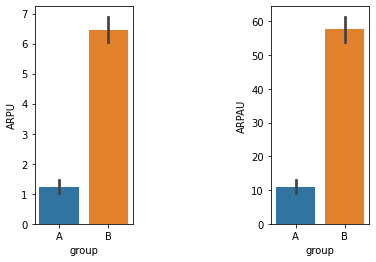

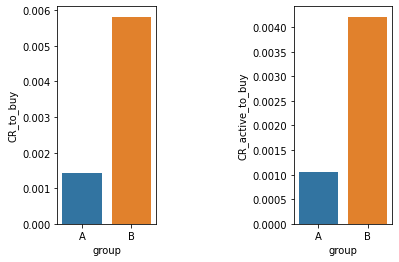

In [60]:
plots()

In [65]:
df = pd.read_csv(path_to_additional, sep = ',', encoding = 'utf-8') # считываем дополнительный файл
added_df = pd.concat([groups_df, df]).reset_index(drop = True) # соединяем счиатнный файл с датафреймом,
added_df['grp'].value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [66]:
active_payable_users = info_df.merge(right = cheks_df, on = 'student_id', how = 'inner').merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id')
active = info_df
payable = cheks_df
active = active.merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id') # при объединении получаем 
# информацию о разделении пользователей на группы
payable = payable.merge(how = 'left', right = added_df, left_on = 'student_id', right_on = 'id')
active['grp'].value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [67]:
payable['grp'].value_counts()

B    434
A    107
Name: grp, dtype: int64

In [68]:
active_payable_users['grp'].value_counts()

B    314
A     78
Name: grp, dtype: int64

In [ ]:
# исходя из графиков, что показаны выше, видно, что метрики для группы Б выше, чем для А. Однако также заметно, что количество
# собранной для группы А информации почти в 4 раза меньше, чем для группы Б. Большее колчество пользователей из другой группы, 
# и, соответственно, информации об их платежах завышает показатели метрик при рассмотрении их относительно разных групп.
# Такая диспропорция в делении пользователей на группы могла повлиять также на результаты АБ-теста, сделав выводы о его 
# результатах неверными. 